# <center> Geostatistical Modelling 2021 - Final Assignment </center>
___
## <center> -- Ordinary Kriging and Sequential Gaussian Simulation -- </center>
<center>Ryan Bobby Andika (416609)<center>

# MODULES & DATA READING

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from scipy.interpolate import griddata
import matplotlib.cm as cm # matplotlib's color map library

In [2]:
# Read original data
df = pd.read_csv('dataset19.csv')
df.head()

,X [km],Y [km],Facies
0,70,66,Facies B
1,10,42,Facies A
2,70,71,Facies B
3,24,67,Facies B
4,87,89,Facies A


# FACIES MAP
We want to Plot the map distribution of Facies A and Facies B. In order to plot the **Facies** Feature into 2D Map, and also to take into account such feature for later Geostatistical Modeling, the transformation of such feature into **Binary Value (1 & 0)** should be conducted.

The Flow of Processing:
<ol>
    <li>Use <b>pd.get_dummies</b> to create two features of Facies with binary values.</li>
    <li>Drop one feature to simplify the Feature for Facies with notation <b>Facies A: 1 & Facies B: 0 </b>.</li>
    <li>Updated Data Frame with additional Binary Value for Facies.</li>
    <li>Plot the Feature of Facies, in the sense of its (x,y) location, into a 2D Map.</li>
</ol>

In [3]:
#Column for Facies (Facies A = 1 // Facies B = 0)
facies = pd.get_dummies(df["Facies"],drop_first=True)
df.drop(['Facies'],axis=1,inplace=True)
df = pd.concat([df,facies],axis=1)
df.columns = ['X', 'Y', 'Facies']
df['Facies'] = 1 - df['Facies']
df.head()

,X,Y,Facies
0,70,66,0
1,10,42,1
2,70,71,0
3,24,67,0
4,87,89,1


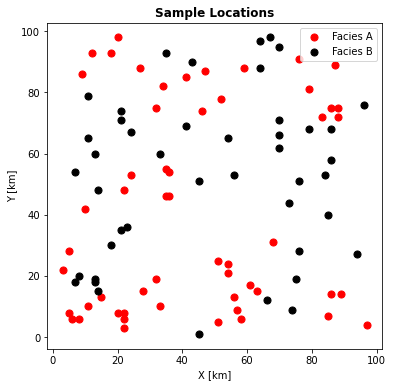

In [4]:
#Plot Observed Data

#Seperate Facies A and Facies B
cond = df.Facies == 1
facies_a = df[cond].dropna()
facies_b = df[~cond].dropna()

#Extra
plt.figure(figsize=(6,6))
plt.scatter(facies_a.X, facies_a.Y, s=50, c='r', label='Facies A')
plt.scatter(facies_b.X, facies_b.Y, s=50, c='k', label='Facies B')
plt.title('Sample Locations', fontweight = 'bold')
plt.xlabel('X [km]')
plt.ylabel('Y [km]')
plt.legend()

# VARIOGRAM MODEL
**Variogram** is a tool to display variability between data points as a function of distance. There are two type of Variogram that we should determine:
<ol>
    <li><b>Experimental Variogram</b> is the plot of  average of semivariance ($\hat{\gamma}$)  within particular range from the experiment versus the lag distance ($\vec{h}$).  
    <li><b>Theoretical Variogram</b> is a pre-defined variogram function (Exponential, Gaussian, Spherical) that best-fit the experimental variogram so that the variogram has a physical meaning. 
</ol>

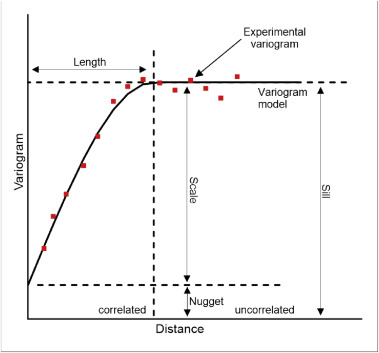
___
<center> <b>Variogram Model (Barca et al., 2017)</b> <center>

## A. Experimental Variogram
The Flow of Processing:
<ol>
    <li>Create a matrix of Lag Distance (h) among observed data using <b>scipy.spatial.distance</b>.</li>
    <li>Calculate the Semivariance ($\hat{\gamma}$) of the Facies using the following equation.</li>
    <li><b>Normalizing or Scaling</b> the result value of Semivariance into <b>(0 - 1)</b>.</li>
    <li>Binning the plot between Lag Diastance ($\vec{h}$) and Semivariance ($\hat{\gamma}$), and calculate the average of each binning to represent the Semivariance ($\hat{\gamma}$) value.</li>
</ol>
$$\hat{\gamma}(\vec{h}) = 0.5  \left(f(\vec{x_i}+\vec{h}) - f(\vec{x_i})\right)^2 $$

In [5]:
#Distance Between Observed Data
from scipy.spatial import distance as dist
loc = np.array([df.X,df.Y]).T
distance = dist.squareform(dist.pdist(loc), 'euclidean')

np.size(dist.pdist(loc))

4753

In [6]:
def semivariances(data):
    """Semivariance calculation for single lag distance
    
    **Arguments**:
        - data = np.array : input array of Facies
        
    **Returns**:
        - gamma = np.array : Matirx of Semivariance for certain lag
    """
    gam=[]
    num = len(data)
    for i in range(num):
        for j in range(num):
            gam.append(0.5*((data[j] - data[i])**2))
    gamma = np.array(gam)
    return gamma

gamma = semivariances(df.Facies.values)

gamma.flatten().shape

<ipython-input-6-2c116f827c03>:14: RuntimeWarning: overflow encountered in ubyte_scalars
  gam.append(0.5*((data[j] - data[i])**2))


(9604,)

Text(0, 0.5, 'Semivariance (ɣ)')

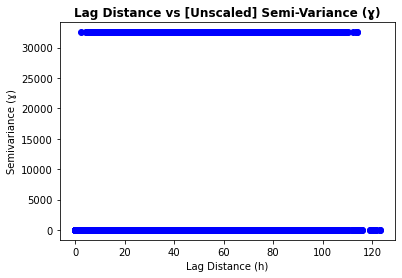

In [7]:
#Plot The Calculated Semivariance
h = distance.flatten()
gamma = gamma.flatten()
plt.scatter(h,gamma, color = 'b')
plt.title('Lag Distance vs [Unscaled] Semi-Variance (ɣ)', fontweight = 'bold')
plt.xlabel('Lag Distance (h)')
plt.ylabel('Semivariance (ɣ)')

In [8]:
# Semivariance normalization
#min-max normalization
gamma_scaled=(gamma-min(gamma))/(max(gamma)-min(gamma))

#Dataframe for Semi-Variogram
siap = {'h':list(h), 'gamma':list(gamma_scaled)}
df_sv = pd.DataFrame(siap, columns =['h','gamma'])

#Sort the Semi-Variogram Datafram
df_sv.sort_values(by='h', ascending=True, inplace=True)
df_sv = df_sv.reset_index(drop=True)
df_sv.head()

,h,gamma
0,0.0,0.0
1,0.0,0.0
2,0.0,0.0
3,0.0,0.0
4,0.0,0.0


Text(0, 0.5, 'Semivariance (ɣ)')

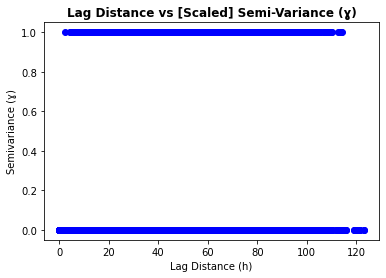

In [9]:
#Plot Semivariance vs Lag Distance

plt.scatter(h,gamma_scaled, color = 'b')
plt.title('Lag Distance vs [Scaled] Semi-Variance (ɣ)', fontweight = 'bold')
plt.xlabel('Lag Distance (h)')
plt.ylabel('Semivariance (ɣ)')

In [10]:
#Creating Experimental Variogram Model

#Parameters for binning
start = 0
stop = max(h)/2 
bin_size = 6

# Step 1: Define number of bins
num_bin = int((stop - start) / bin_size)

# Step 2: Define empty container for avarage value of Bins and Semivariance 
ave_vals = []
h_bins = []
mask = [[] for _ in range(num_bin)]

# Step 3: Loop of range equal to defined number of bins
for i in range(num_bin):

    # 3.1 Create a mask for distance step plus lag step (start with first bin)
    ##Call all the Lag Distance data in particular Lag Distance Range, otherwise call as 0
    mas = np.where(((df_sv['h'] > num_bin*i) & (df_sv['h'] < num_bin*(i+1))),df_sv['h'],0)
    
    ##Get rid of all 0 value after np.where function using filter, include it into mask[i] as a list
    mask[i] = list(filter(lambda a: a != 0, mas))
    
    #Link the data
    z=df_sv[df_sv['h'].isin(mask[i])] 
    
    # 3.2 Apply mask to gamma and calculate and store the average value of it
    ave_vals.append(np.average(z['gamma']))
    
    # 3.3 Calculate value for the central lag distance for each bin and store it
    h_bins.append(np.average(mask[i]))  

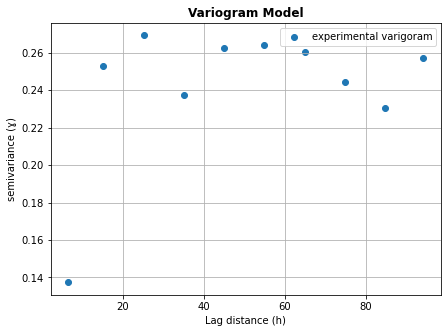

In [11]:
#Plotting Experimental Variogram Model
plt.figure(figsize=(7,5))
plt.scatter(h_bins,ave_vals, label="experimental varigoram")
plt.title('Variogram Model', fontweight = 'bold')
plt.xlabel('Lag distance (h)')
plt.ylabel('semivariance (ɣ)')
plt.grid()
plt.legend()

## Discussion: Experimental Variogram
From the plot of Experimental Variogram, it is learned that such variogram has **Range at 21** and **Sill at 0.255**. However, we are not using Experimental Variogram as our property of spatial relationship. We should define the Theoretical Variogram instead.
___

## B. Theoretical Variogram
The Flow of Processing:
<ol>
    <li>Plot the Experimental Variogram Result</b>.</li>
    <li>Define the <b>Theoretical Function of Exponential</b> ($exp{(\vec{h})}$) like in the following equation</li>
    <li>Define the proper <b>Range and Sill</b> (based on the Experimental Variogram) for the Exponential Function. This function would be our property of dissimilarity that we use for further processing.</li>
    <li>Define the <b>theoretical best-fitting Exponential Function</b> toward the distribution data of Experimental Variogram (Green Dot) .</li>
</ol>
$$exp{(\vec{h})} = c_0  \left(1 - exp{\frac{(-3)\vec{h}}{r}}\right) $$

In [12]:
#Guessed Range & Sill
range_ = 21
sill_ = 0.255

# The exponential variogram function (just defined by this equation, recall lecture)
def exp_var(lag, r, c0):
    return c0 * (1 - np.exp((-3 * lag)/r))

In [13]:
# import additional library for curve fit
import scipy.optimize
from scipy.optimize import curve_fit

[20.28752759  0.25536518]


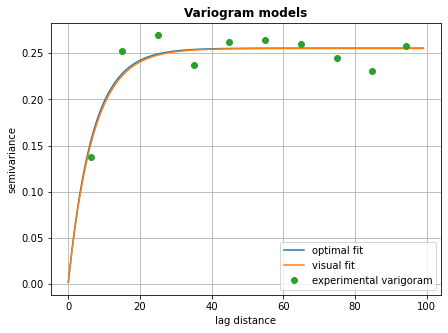

In [14]:
# Finding an optimal fit:
par_a, par_b = curve_fit(exp_var, h_bins, ave_vals, p0=[100,600])
print(par_a)

x = np.arange(0.05,100,1)
plt.figure(figsize=(7,5))
plt.plot(x, exp_var(x, par_a[0], par_a[1]), label="optimal fit")
plt.plot(x, exp_var(x, range_, sill_), label="visual fit")
plt.plot(h_bins, ave_vals, 'o', label="experimental varigoram")
plt.ylabel("semivariance")
plt.xlabel("lag distance")
plt.title("Variogram models", fontweight = 'bold')
plt.legend()
plt.grid()

## Discussion: Theoretical Variogram
From the plot, it is evident that we use the **Exponential Function** as our Theoretical Variogram with **Range at 21** and **Sill at 0.255**. Hence, we could use such statistical properties for next Geostatistical Modelling and Simulation to see Facies Distribution of **A** and **B**.
___

# ORDINARY KRIGING
Back to the basic theory and mathematical equation of **Simple Kriging**, we know that such estimation method **required us to use a pre-defined mean**. This case could lead to bias results as a dataset in a particular area that we used may consist of some lower influence data. A simple case is in the borehole data where the compactness of, let say, the same lithology of Sandstone toward depth might have different properties that have to take into account (Tight or Loose Sandstone).

Here in the **Ordinary Kriging**, we are allowed to **direct use of Theoretical Variogram** ($\gamma$) (instead of the Covariance function like in the Simple Kriging Function). The estimation method also enables us not to use pre-defined mean values. We are actually allowed to estimate the mean value directly from our data in the Ordinary Kriging step.

Estimatior for Ordinary Kriging:

$$ Z^*_{\omega_{OK}}(x_0)= \sum_{i=1}^{n}\omega_i (Z(x_i))$$

Conditions:
$$ \sum_{i=1}^{n}\omega_i ^{OK} = 1 $$

$$C \sum_{i=1}^{n}\omega_i ^{OK} \gamma (x_i - x_j) +\lambda_{OK} = \gamma(x_i - x_j)$$ with $\lambda\$ is Lagrange Multiplier and for $$i = 1,...,n$$

In [15]:
def ordinary_kriging(a, b, prop, range_, sill_):
    """Kriging for single location
    
    **Arguments**:
        - a (np.array) = distance between input data points (n x n)
        - b (np.array) = distance vetor between target and input data points (n)
        - prop (np.array) = values of input data (n)
        - range_ (float) = range parameter of variogram model
        - sill (np.array) = sill parameter of variogram model
        
    **Returns**:
        - result (float) = calculated kriging result
        - pred_var (float) = calculated kriging variance
        - w (np.array) = calculated kriging weights
    """
    #Creating empty matrices
    shape = len(a)
    C = np.zeros((shape + 1, shape + 1))
    c = np.zeros((shape + 1))
    w = np.zeros((shape + 1))

    #filling Matrices based distance matrices and model for spatial correlation
    C[:shape, :shape] = exp_var(b, range_, sill_)
    c[:shape] = exp_var(a, range_, sill_)
    
    np.fill_diagonal(C,0)

    #Fill additional matrix entries, specifically for OK
    C[shape, :] = 1.0
    C[:, shape] = 1.0
    C[shape, shape] = 0.0
    c[shape] = 1.0

    #Solve Kriging equations for weights
    w = np.linalg.solve(C,c)

    #Section: weight correction following Deutsch (1996)
    # 1. Negative Weights to zero
    w[w<0] = 0

    # 2. correct screening effect
    average_magnitude_of_negative_weights = np.mean(w[w>0])
    average_covariance_of_negative_weights = np.mean(c[w>0])
    mask = (w>0) & (c<average_covariance_of_negative_weights) & (w<average_magnitude_of_negative_weights)
    w[mask]=0

    # 3. restandardize to one
    w = w/np.sum(w)
    #End Section: weight correction following Deutsch (1996)

    #Calculating estimate abd variance for kriging
    pred_var = w[shape] + np.sum(w[:shape] * c[:shape])
    result = np.dot(prop, w[:shape])

    return result, pred_var, w

In [16]:
#Domain extend (100 x 100 km) and gridding for Ordinary Kriging Estimation
#Change resol_grid to adjust the resolution (Trial = 50)
resol_grid = 50
grid_xy = np.array([[i,j] for i in np.linspace(0,100,resol_grid, dtype='int') for j in np.linspace(0,100,resol_grid, dtype='int')])

In [17]:
#Estimation Result in Domain of Ordinary Kriging 
result_ok=[]
var_ok=[]
for i in np.linspace(0,100,resol_grid, dtype='int'):
    for j in np.linspace(0,100,resol_grid, dtype='int'):
        dem = dist.cdist(loc,np.array([[i,j]]))
        result_ok.append(ordinary_kriging(dem.flatten(), distance, df['Facies'], range_, sill_)[0])
        var_ok.append(ordinary_kriging(dem.flatten(), distance, df['Facies'], range_, sill_)[1])

In [18]:
#Dataframe for Ordinary Kriging Result
df_ok = pd.DataFrame(grid_xy, columns = ['X', 'Y'])
df_ok['Probability Facies A'] = result_ok
df_ok['Probability Facies B'] = 1 - np.array(result_ok)
df_ok['Facies Category'] = 0
df_ok['Prediction Variance']=var_ok
df_ok

,X,Y,Probability Facies A,Probability Facies B,Facies Category,Prediction Variance
0,0,0,0.837783,0.162217,0,0.213536
1,0,2,0.899135,0.100865,0,0.193069
2,0,4,0.923631,0.076369,0,0.173249
3,0,6,0.943874,0.056126,0,0.157508
4,0,8,0.905612,0.094388,0,0.154268
...,...,...,...,...,...,...
2495,100,91,0.552765,0.447235,0,0.247115
2496,100,93,0.576410,0.423590,0,0.250581
2497,100,95,0.545242,0.454758,0,0.253827
2498,100,97,0.544945,0.455055,0,0.256508


In [19]:
# Gridding Function for Ordinary Kriging Interpolation Map
def grid_z_ok(x_ok, y_ok, z_ok):
    x = x_ok
    y = y_ok
    z = z_ok

    # target grid to interpolate to
    xa = ya = np.linspace(0,100,resol_grid,dtype='int')
    xa,ya = np.meshgrid(xa,ya)

    # interpolate
    za = griddata((x,y),z,(xa,ya))
    
    return xa,ya,za

In [20]:
# Griding for Probability Facies A and Probability Facies B maps using Ordinary Kriging function
xa, ya, za = grid_z_ok(df_ok['X'],df_ok['Y'],df_ok['Probability Facies A'])
xb, yb, zb = grid_z_ok(df_ok['X'],df_ok['Y'],df_ok['Probability Facies B'])

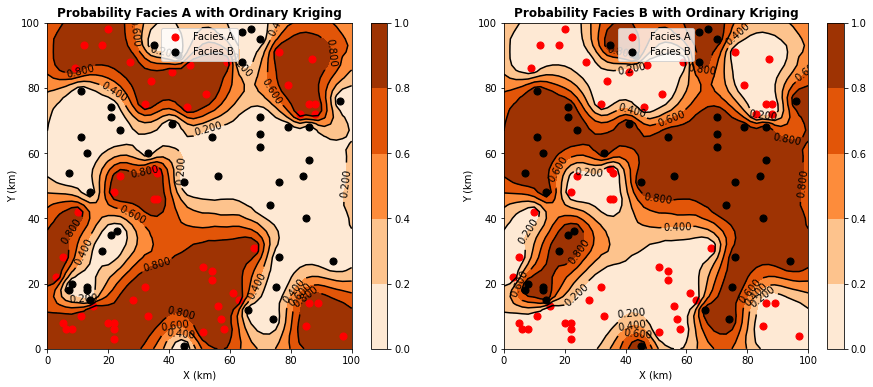

In [21]:
# Initialize plot objects
plt.rcParams['figure.figsize'] = 15, 6
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

# Define a countour map
levels = np.array([0.2,0.4,0.6,0.8,1])

# Define a color mapping with contour consideration
cpf_a = ax1.contourf(xa, ya, za, len(levels), cmap=cm.Oranges)
cpf_b = ax2.contourf(xb, yb, zb, len(levels), cmap=cm.Oranges)

# Define the contour level lines to black
line_colors_a = ['black' for l in cpf_a.levels]
line_colors_b = ['black' for l in cpf_b.levels]

# Make plot
cpa = ax1.contour(xa, ya, za, levels=levels, colors=line_colors_a)
ax1.clabel(cpa, fontsize=10, colors=line_colors_a)
ax1.set_title('Probability Facies A with Ordinary Kriging', fontweight = 'bold')
ax1.set_xlabel('X (km)')
ax1.set_ylabel('Y (km)')
ax1.scatter(facies_a.X, facies_a.Y, s=50, c='r', label='Facies A')
ax1.scatter(facies_b.X, facies_b.Y, s=50, c='k', label='Facies B')
fig.colorbar(cpf_a, ax=ax1)
ax1.legend()

cpb = ax2.contour(xb, yb, zb, levels=levels, colors=line_colors_b)
ax2.clabel(cpb, fontsize=10, colors=line_colors_b)
ax2.set_title('Probability Facies B with Ordinary Kriging', fontweight = 'bold')
ax2.set_xlabel('X (km)')
ax2.set_ylabel('Y (km)')
ax2.scatter(facies_a.X, facies_a.Y, s=50, c='r', label='Facies A')
ax2.scatter(facies_b.X, facies_b.Y, s=50, c='k', label='Facies B')
fig.colorbar(cpf_b, ax=ax2)
ax2.legend()

## Discussion: Ordinary Kriging
From the result of Ordinary Kriging above, we should note that the result only provides us with the **Probability Value of particular facies** in unknown value locations. If we see for the left map, we should grasp that the more its value is into 1, then the location has favors to be a Facies A and the other way around for Facies B for the right map. Moreover, In general, the results are statistically giving us a representative Probability Distribution Value for both Facies A and Facies B as its value contour could bound two different Facies correctly.  

The important thing that we should note from these results is that in the area where there are no known data, the Probability Value will mathematically have a mean value (0.5 - 0.6). But then it is getting higher or lower again toward known data in the area. Here is the specialty of Kriging or Geostatistical method in general that the equation able to make the estimation of unknown value of data by **linking the value of all known data and its spatial relationship configuration**. The closer the unkown value to the data of Facies A for the left map, the higher probability value we got, and the same case for Facies B on the right map.
___

# FACIES MAP (CATEGORY) BY ORDINARY KRIGING
We have finished with the Facies Distribution for A and B using the Ordinary Kriging estimation method. However, such results only tell us about the Probability of particular Facies. Here, in this case, we want to convert the probability result into a **category or binary values (1 or 0)** to represent the **Facies A (1)** and **Facies B (0)** Map distribution. The conversion that I code in here is quite simple as from the Probability Facies A result, I define a condition of:

<ol>
    <li>Probability Facies A $>$ 0.5 = <b>1 (Facies A)</b></li>
    <li>Probability Facies A $\le$ 0.5 = <b>0 (Facies B)</b></li>
</ol>

In [22]:
#If Condition for Categorical type of Facies
for i in range(len(df_ok)):
    if df_ok['Probability Facies A'][i] > 0.5:
        df_ok['Facies Category'][i] = 1
    else:
        df_ok['Facies Category'][i] = 0

<ipython-input-22-315ef1f34361>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ok['Facies Category'][i] = 1
<ipython-input-22-315ef1f34361>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ok['Facies Category'][i] = 0


In [23]:
# Griding for Categorical Facies map using Ordinary Kriging function
xc, yc, zc = grid_z_ok(df_ok['X'],df_ok['Y'],df_ok['Facies Category'])

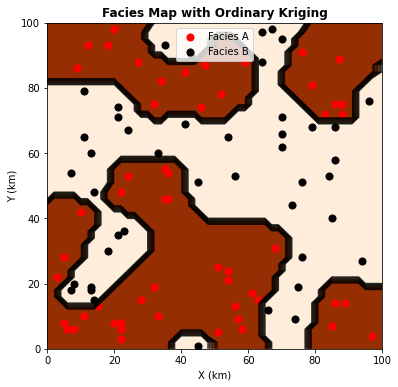

In [24]:
# Initialize plot objects
plt.rcParams['figure.figsize'] = 6, 6
fig = plt.figure()
ax1 = fig.add_subplot(111)

# Define a color mapping with contour consideration
cpf = ax1.contourf(xc, yc, zc, cmap=cm.Oranges)

# Define the lines to black
line_colors_a = ['black']

# Make plot
cp = ax1.contour(xc, yc, zc, colors=line_colors_a, alpha=0.8)
ax1.set_title('Facies Map with Ordinary Kriging', fontweight = 'bold')
ax1.set_xlabel('X (km)')
ax1.set_ylabel('Y (km)')
ax1.scatter(facies_a.X, facies_a.Y, s=50, c='r', label='Facies A')
ax1.scatter(facies_b.X, facies_b.Y, s=50, c='k', label='Facies B')
ax1.legend()

#export
plt.savefig('OK_Facies.png')

## Discussion: Facies Map (Category) by Ordinary Kriging
The categorical facies map by the condition that I set up for the Probability Facies Map Result from the previous task is quite representative. The Boundary between the data distribution of Facies A and Facies B is clear in separating those facies. Even an outlier data of Facies B on location around (40,0), which I actually doubt about its continuity but will be discussed later, the Boundary can still separate the facies from surrounding data Facies A. 

The result of this categorical map by Ordinary Kriging might giving us an insight into the body of facies in our area. Is it geologically make sense? of course we have no idea about it. **We will not able to create a whole story about these facies distribution in the subsurface**. In Additional, I doubt the result on location around (15, 43) as it represents a small body continuation between the lower and upper Facies B data crowd. Therefore, we need to consider a different method to solve this spatial closeness configuration issue mathematically.
___

# Sequential Gaussian Simulation (SGS)
**Kriging estimation always creates a smoother representation of the property than the actual property**, as estimated from variogram analysis. Moreover, the estimation result at the range beyond the observed data points tends to face the **smoothing effect of kriging**. In order to overcome this problem, the idea is we have to update our estimate of mean and variance at positions close to the point in our dataset so that the **Spatial Closeness Configuration** that being inherited in Kriging Estimation could still be regarded during estimation. Therefore, **Sequential Gaussian Simulation** can be used to implement that idea.

The Main steps in SGS:
<ol>
    <li><b>Create a grid for data sampling</b> from the distribution of known data.</li>
    <li><b>Pick a location randomly</b> in the grid where the value is not known yet.</li>
    <li><b>Estimate the value</b> on that location from the interpolation by a particular geostatistical method.</li>
    <li>Pick the value of estimation randomly in step 3 within its <b>Normal Distribution and Variance of the estimated data</b>.</li>
    <li>Add the Random pick value from step 4 and its location to the known data (<b>updating the dataset of known data</b>).</li>
    <li><b>Repeat step 1 - 5</b> until all the location from the defined grid being sampled</li>
</ol>

In [25]:
#Domain extend (100 x 100 km) and gridding for SGS Estimation.
#Change resol_sgs to adjust the resolution (Trial = 10)
resol_sgs = 10
grid_xy_sgs = np.array([[i,j] for i in np.linspace(0,100,resol_sgs, dtype='int') for j in np.linspace(0,100,resol_sgs, dtype='int')])

#Dataframe for Domain Estimation
dom_sgs = pd.DataFrame(grid_xy_sgs, columns = ['X', 'Y'])
df_sgs_domain = pd.DataFrame(data=dom_sgs)
df_sgs_domain

,X,Y
0,0,0
1,0,11
2,0,22
3,0,33
4,0,44
...,...,...
95,100,55
96,100,66
97,100,77
98,100,88


In [26]:
def sgs_interp(grid_domain,input_data,kriging_method):
    """Full SGS Estimation
    
    **Arguments**:
        - grid_domain = Domain for SGS estimation (Dataframe {x, y})
        - input_data = Observed Data (Dataframe {x, y, value})
        - kriging_method = Pre-Defined Function of Kriging Estimation (In this case, the option is only 'Ordinary Kriging')
        
    **Returns**:
        - df_sgs = Estimation Result (Dataframe {x, y, estimation result, estimated variance})
    """
    #The used observed data for SGS
    df_sgs = input_data
    
    #Creating the coordinate position (x,y) and calculate all the distance between the observed data
    loc_sgs = np.array([df_sgs.X,df_sgs.Y]).T
    distance_sgs = dist.squareform(dist.pdist(loc_sgs), 'euclidean') 
    
    #STEP 1: Shuffling the dataframe of domain SGS (df_sgs_domain) to represent the random sampling step in SGS
    grid_rand = grid_domain.sample(frac=1).reset_index(drop = True)


    #STEP 2: Acquire estimation result (In Categorical Type) and estimated variance for each location in defined domain for SGS 
    for m in range(len(grid_rand)):
        dem_grid_data = dist.cdist(loc_sgs,np.array([[grid_rand.X[m],grid_rand.Y[m]]]))
    
        #In my case, I have to use try/except to avoid the Matrix Singularity (The determinant of the Covariance resulting 0) during kriging estimation. 
        try:
            tem_res_sgs_data = kriging_method(dem_grid_data.flatten(), distance_sgs, df_sgs['Facies'], range_, sill_)[0]
            tem_var_sgs_data = kriging_method(dem_grid_data.flatten(), distance_sgs, df_sgs['Facies'], range_, sill_)[1]

            if tem_res_sgs_data > 0.5:
                tem_res_sgs_data = 1
            else:
                tem_res_sgs_data = 0
        
        #If my code have an error due to Matrix Singularity, the estimation result will be replaced by random pick of estimation result from the normal distribution.
        #This trick work for me so that the process will not stop due to Matrix Singularity.
        except:
            tem_res_sgs_data = np.random.normal(tem_res_sgs_data, np.sqrt(tem_var_sgs_data))

            if tem_res_sgs_data > 0.5:
                tem_res_sgs_data = 1
            else:
                tem_res_sgs_data = 0

        #STEP 3: Include the estimated data into Observed Data for next estimation
        tem_df_sgs_data = pd.DataFrame({'X': grid_rand.X[m], 'Y': grid_rand.Y[m], 'Facies': [tem_res_sgs_data], 'Variance' : [tem_var_sgs_data]})
        df_sgs = df_sgs.append(tem_df_sgs_data, ignore_index = True)

        #Update the coordinate position (x,y) and all the distance between the observed data
        loc_sgs = np.array([df_sgs.X,df_sgs.Y]).T
        distance_sgs = dist.squareform(dist.pdist(loc_sgs), 'euclidean')
    
    #The estimated variance in Observed data is 0 (Change from Nan to 0)
    df_sgs['Variance'] = df_sgs['Variance'].fillna(0)
    return df_sgs

In [27]:
#Estimation Result in Domain of SGS 
df_sgs = sgs_interp(df_sgs_domain, df, ordinary_kriging)
df_sgs

,X,Y,Facies,Variance
0,70,66,0,0.000000
1,10,42,1,0.000000
2,70,71,0,0.000000
3,24,67,0,0.000000
4,87,89,1,0.000000
...,...,...,...,...
193,11,11,1,0.062971
194,11,55,0,0.139195
195,66,44,0,0.191533
196,33,55,1,0.103828


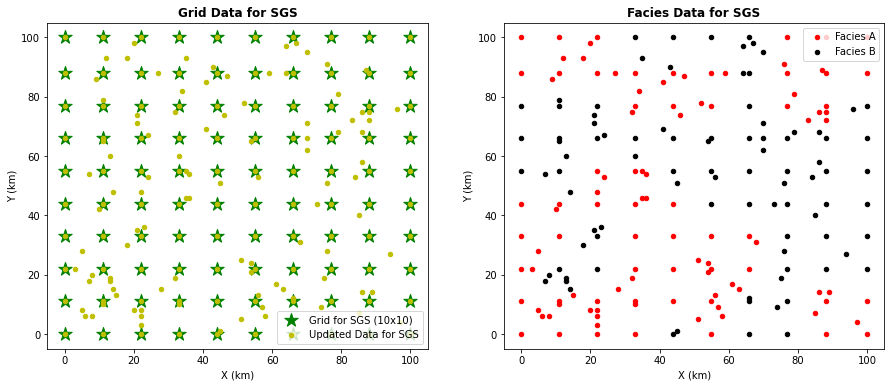

In [28]:
#Data Ploting of SGS Domain

# Initialize plot objects
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

#Seperate Facies A and Facies B from SGS result
condi = df_sgs['Facies'] == 1
facies_a_sgs = df_sgs[condi].dropna()
facies_b_sgs = df_sgs[~condi].dropna()

#Extra
ax2.scatter(facies_a_sgs['X'], facies_a_sgs['Y'], s=20, c='r', label='Facies A')
ax2.scatter(facies_b_sgs['X'], facies_b_sgs['Y'], s=20, c='k', label='Facies B')
ax2.set_xlabel('X (km)')
ax2.set_ylabel('Y (km)')
ax2.set_title('Facies Data for SGS', fontweight = 'bold')
ax2.legend()

ax1.scatter(df_sgs_domain['X'], df_sgs_domain['Y'],marker='*', s=200, c='g', label='Grid for SGS (10x10)')
ax1.scatter(df_sgs['X'], df_sgs['Y'],marker='o', s=20, c='y', label='Updated Data for SGS')
ax1.set_xlabel('X (km)')
ax1.set_ylabel('Y (km)')
ax1.set_title('Grid Data for SGS', fontweight = 'bold')
ax1.legend()

In [29]:
# Gridding Function for SGS
def grid_z_sgs(x_sgs, y_sgs, z_sgs, res):
    x = x_sgs
    y = y_sgs
    z = z_sgs

    # target grid to interpolate to
    xi = yi = np.linspace(0,100,res,dtype='int')
    xi,yi = np.meshgrid(xi,yi)

    # interpolate
    zi = griddata((x,y),z,(xi,yi),method='nearest')
    
    return xi,yi,zi

In [30]:
# Griding for Categorical Facies map using SGS function
df_sgs = sgs_interp(df_sgs_domain, df, ordinary_kriging)
xi, yi, zi = grid_z_sgs(df_sgs['X'], df_sgs['Y'], df_sgs['Facies'],100)

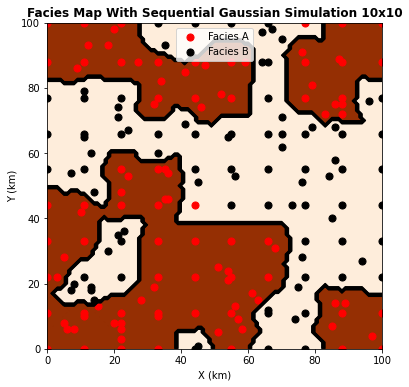

In [31]:
# Data ploting for Facies Map of SGS Estimation

# Initialize plot objects
plt.rcParams['figure.figsize'] = 6, 6 # sets plot size
fig = plt.figure()
ax1 = fig.add_subplot(111)

# Generate a color mapping with the level of resolution
cpf = ax1.contourf(xi,yi,zi,cmap=cm.Oranges)

# Set the level lines to black
line_colors_a = ['black']

#Extra
cp = ax1.contour(xi,yi,zi, colors=line_colors_a)
ax1.scatter(facies_a_sgs.X, facies_a_sgs.Y, s=50, c='r', label='Facies A')
ax1.scatter(facies_b_sgs.X, facies_b_sgs.Y, s=50, c='k', label='Facies B')
ax1.set_title('Facies Map With Sequential Gaussian Simulation '+str(resol_sgs)+'x'+str(resol_sgs), fontweight = 'bold')
ax1.set_xlabel('X (km)')
ax1.set_ylabel('Y (km)')
ax1.legend()

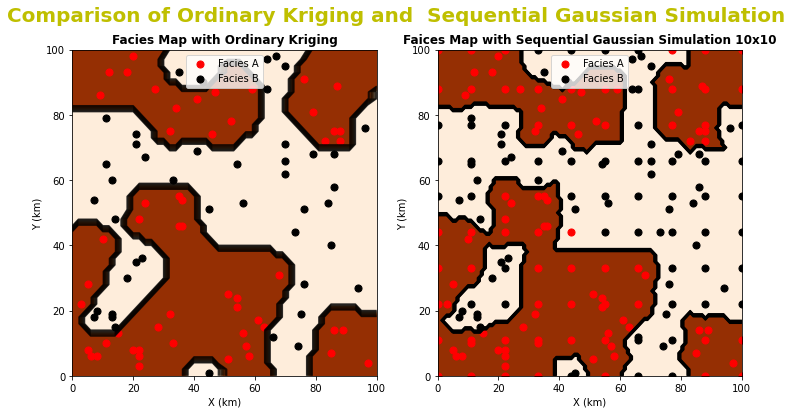

In [32]:
#Data Ploting of SGS Domain

# Initialize plot objects
fig = plt.figure(figsize=(12,6))
fig.suptitle("Comparison of Ordinary Kriging and  Sequential Gaussian Simulation", fontsize=20, fontweight='bold', c='y')

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

# Generate a color mapping with the level of resolution
cpfaa = ax1.contourf(xc,yc,zc,cmap=cm.Oranges)
cpfbb = ax2.contourf(xi,yi,zi,cmap=cm.Oranges)

# Set the level lines to black
line_colors_a = ['black']

#Extra
cp1 = ax1.contour(xc, yc, zc, colors=line_colors_a, alpha=0.8)
ax1.set_title('Facies Map with Ordinary Kriging', fontweight = 'bold')
ax1.set_xlabel('X (km)')
ax1.set_ylabel('Y (km)')
ax1.scatter(facies_a.X, facies_a.Y, s=50, c='r', label='Facies A')
ax1.scatter(facies_b.X, facies_b.Y, s=50, c='k', label='Facies B')
ax1.legend()

cp2 = ax2.contour(xi,yi,zi, colors=line_colors_a)
ax2.scatter(facies_a_sgs.X, facies_a_sgs.Y, s=50, c='r', label='Facies A')
ax2.scatter(facies_b_sgs.X, facies_b_sgs.Y, s=50, c='k', label='Facies B')
ax2.set_title('Faices Map with Sequential Gaussian Simulation '+str(resol_sgs)+'x'+str(resol_sgs), fontweight = 'bold')
ax2.set_xlabel('X (km)')
ax2.set_ylabel('Y (km)')
ax2.legend()

## Discussion: Facies Map (Category) by Sequential Gaussian Simulation
The result of the Sequential Gaussian Simulation above has addressed the doubt that I highlighted in the previous discussion about the small continuation on location around (15, 43). The application of Spatial Closeness Configuration in Kriging Estimation has to give us a **"Potential Correct" representation of Facies Body** in that location by adding more 'artificial-statistical' known data during the estimation. Why is it not called **"the best" representation of Facies Body** after SGS deployed? It is because **SGS still used the "original" spatial relationship (Variogram) to produce the additional known data and making the estimation**. This fact indicates that the SGS application did not give us the **"Primary Data"** or "Actual Data" from the site. It just **utilizes the inherited character of Spatial Closeness Configuration in Kriging** to make the additional data, to produce more options of estimation results, which should also be better due to more data being regarded during the process.

Additional data from the 10x10 resolution in the range of "Original" known data deployed in this SGS estimation. The result with more known data still as representative as Ordinary Kriging estimation result, because the Boundary between the data distribution of Facies A and Facies B is clear in separating those facies.
___

# Multiple Realizations by Sequential Gaussian Simulation.
One of the advantages of using the SGS method is that we can create multiple realizations as the random scheme within the estimation process is applied. In order to create the multiple realizations, I just used the $for-loop$ tool from one SGS to another SGS. **The inheritance of random scheme in SGS** will automatically provide us a new set of data for each SGS realization. 

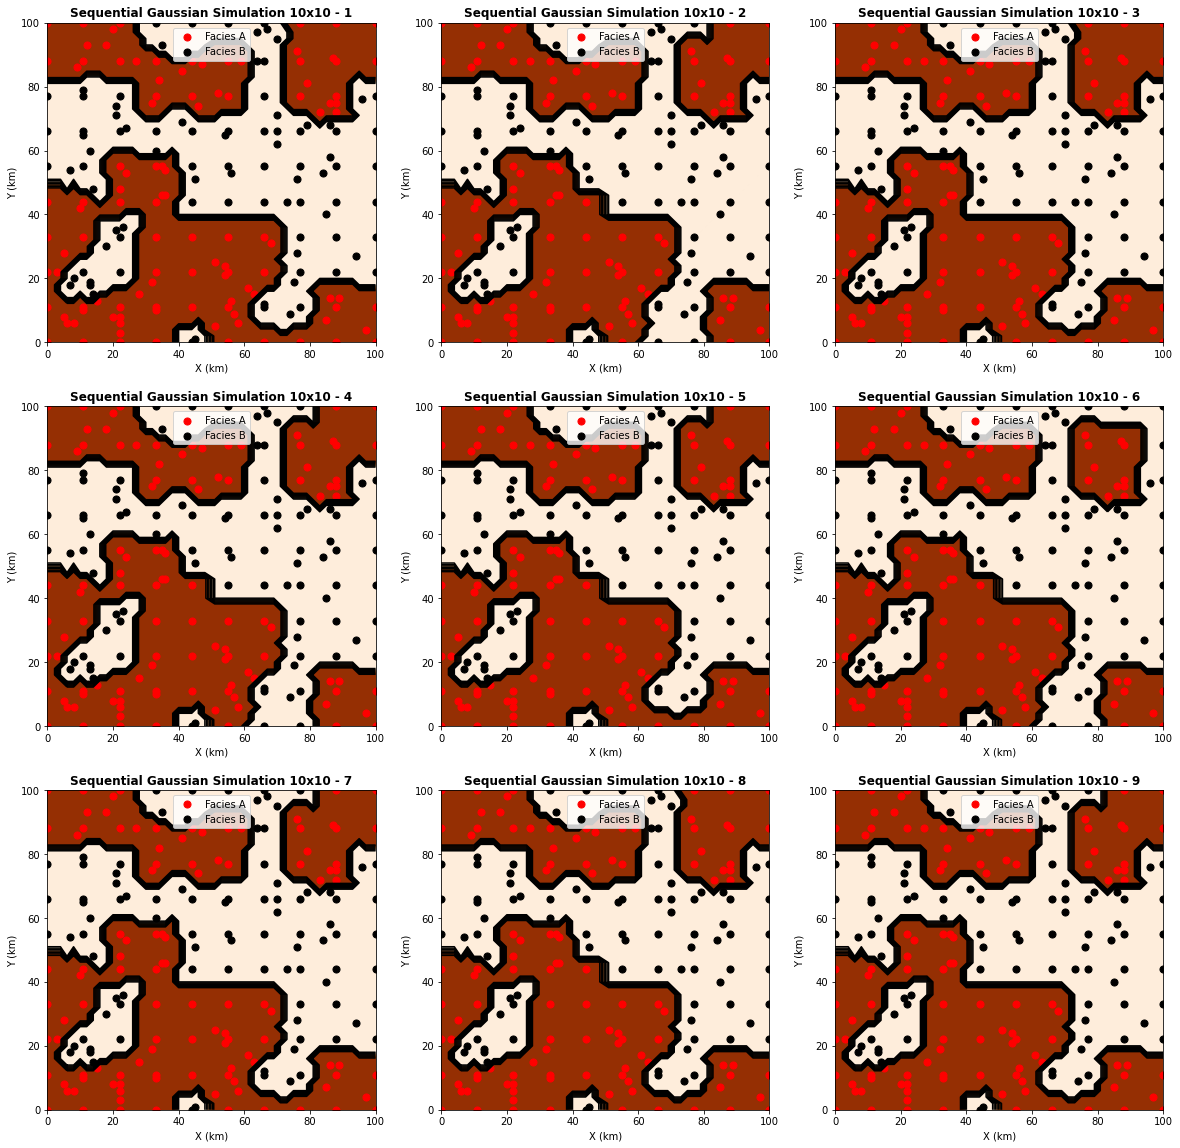

In [33]:
# Conduct 9 Realization of SGS estimation. I reduce the resolution in griding for effective time consuming
fig, axs = plt.subplots(3, 3, figsize=(20,20))
d = 0
for i in range(3):
    for j in range(3):
        #Estimation Result in Domain of SGS
        df_sgs = sgs_interp(df_sgs_domain, df, ordinary_kriging)
        
        # Griding for Categorical Facies map using SGS function
        xi, yi, zi = grid_z_sgs(df_sgs['X'], df_sgs['Y'], df_sgs['Facies'], 50)

        # Data ploting
        # Generate a color mapping with the level of resolution
        cpf = axs[i][j].contourf(xi,yi,zi,cmap=cm.Oranges)

        # Set the level lines to black
        line_colors_a = ['black']
        
        #Seperate Facies A and Facies B from SGS Result
        condi = df_sgs['Facies'] == 1
        facies_a_sgs = df_sgs[condi].dropna()
        facies_b_sgs = df_sgs[~condi].dropna()
        
        #Extra
        d=d+1
        cp = axs[i][j].contour(xi,yi,zi, colors=line_colors_a)
        axs[i][j].scatter(facies_a_sgs.X, facies_a_sgs.Y, s=50, c='r', label='Facies A')
        axs[i][j].scatter(facies_b_sgs.X, facies_b_sgs.Y, s=50, c='k', label='Facies B')
        axs[i][j].set_title('Sequential Gaussian Simulation '+str(resol_sgs)+'x'+str(resol_sgs)+' - '+ str(d), fontweight = 'bold')
        axs[i][j].set_xlabel('X (km)')
        axs[i][j].set_ylabel('Y (km)')
        axs[i][j].legend()
        
        # Reset
        del df_sgs

## Discussion: Multiple Realizations by Sequential Gaussian Simulation.
Based on the multiple realizations above, we noticed that there are some differences toward the **new "Artificial-Statistical" known data** and its estimation map, especially in areas where there is least of "Original" known data. In my recent (below) multiple realization's simulations, I noticed the variation in the upper corner right area, lower right area (which I called a doubtful outlier of Facies B), and around the center of this area (50,50) where the body of Facies A on the surface is changing through all 9 realizations. 

Moreover, the doubt that I highlighted the most in the previous discussion is now crystal clear after these Multiple Realizations by SGS. The small body continuation on location around (15, 43) has disappeared, making the Facies Body more representative from my geological perspective. We could see from these multiple realizations that the **SGS application teaches us about the expected variability or spatial distribution in our data**. However, we should never forget that such variability comes from the Variogram of our "Original" known value data.

In conclusion, both Ordinary Kriging and Sequential Gaussian Simulation giving us a representative spatial distribution of Facies A and Faces B in the sense of statistical and mathematical. The boundary created to separate the Facies A and Facies B produce a mathematically sufficient categorical facies map. The special use of Sequential Gaussian Simulation with a basis of Ordinary Kriging also giving us a more "Potential Correct" to the spatial distribution in nature. In the end, all of these statistical and mathematical things are still **in the corridor of a model, which will always be wrong** compared to nature. However, it is **still helpful and useful** for us if we use it properly.
___

**Expand and uncomment this cell for my Realization Interpretation**
<!-- # Realization
![SGS%2010x10.png](attachment:SGS%2010x10.png) -->

# REFERENCE
[1] Barca, E., Porcu, E., Bruno, D., and Passarella, G., 2017. An automated decision support system for aided assessment of variogram models. Environmental Modelling & Software. Vol 87. PP72-83. https://doi.org/10.1016/j.envsoft.2016.11.004.  
___